In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import plotnine
import os
import re

In [9]:
re_clingo_time = r"(?P<total>[\d.]+)s \(Solving: (?P<solving>[\d.]+)s 1st Model: (?P<sat>[\d.]+)s Unsat: (?P<unsat>[\d.]+)s"
re_clingo = r"clingo_out_(?P<states>[\d]+).out"
header = f"iteration,num_states,cpu_time,time,solve_time,choices,conflicts,restarts,variables,constraints"
def parse_file(file):
    data = {}
    with open(file) as r:
        info = r.readlines()
        for l in info:
            if "CPU Time" in l:
                _s = l.split(":")[-1].strip().replace("s","")
                data["cpu_time"] = float(_s)
            if "Time" in l and "CPU" not in l:
                _s = ":".join(l.split(":")[1:]).strip()
                result = re.match(re_clingo_time, _s)
                sat_time = float(result.group("sat"))
                unsat_time = float(result.group("unsat"))
                data["sat"] = sat_time
                data["unsat"] = unsat_time
                data["total_time"] = float(result.group("total"))
            elif "Choices" in l:
                _s = l.split(":")[-1].strip()
                data["choices"] = int(_s)
            elif "Conflicts" in l:
                _tokens = l.split(":")[1].strip()
                _s = _tokens.split(" ")[0].strip()
                data["conflicts"] = int(_s)
            elif "Restarts" in l:
                _tokens = l.split(":")[1].strip()
                _s = _tokens.split(" ")[0].strip()
                data["restarts"] = int(_s)
            elif "Variables" in l:
                _tokens = l.split(":")[1].strip()
                _s = _tokens.split(" ")[0].strip()
                data["variables"] = int(_s)
            elif "Constraints" in l:
                _tokens = l.split(":")[1].strip()
                _s = _tokens.split(" ")[0].strip()
                data["constraints"] = int(_s)

    return data

def process(output_dir):
    data = []
    _files = [f for f in os.listdir(output_dir) if f.endswith("out")]
    for _f in _files:
        tokens = _f[:-4].split("_")
        n = int(tokens[2])
        info = parse_file(f"{output_dir}/{_f}")
        if info['sat'] > info['unsat']:
            solve_time = info['sat']
        else:
            solve_time = info['unsat']
        row = [n,n,info['cpu_time'],info['total_time'],solve_time,info['choices'],info['conflicts'],info['restarts'],info['variables'],info['constraints']]
        data.append(row)
    return data

In [32]:
ref_1 = "reg2"
ref_2 = "dual"
ref_3 = "reg"

path_1 = f"~/Work/Software/fond-compact-asp/output/beam-walk/p03/asp-{ref_1}"
path_2 = f"~/Work/Software/fond-compact-asp/output/beam-walk/p03/asp-{ref_2}"
path_3 = f"~/Work/Software/fond-compact-asp/output/beam-walk/p03/asp-{ref_3}"

data_1 = process(os.path.expanduser(path_1))
data_2 = process(os.path.expanduser(path_2))
data_3 = process(os.path.expanduser(path_3))

In [33]:
df_1 = pd.DataFrame(data_1, columns=header.split(","))
df_1["ref"] = ref_1

df_2 = pd.DataFrame(data_2, columns=header.split(","))
df_2["ref"] = ref_2

df_3 = pd.DataFrame(data_3, columns=header.split(","))
df_3["ref"] = ref_3

df = pd.concat([df_1, df_2, df_3])

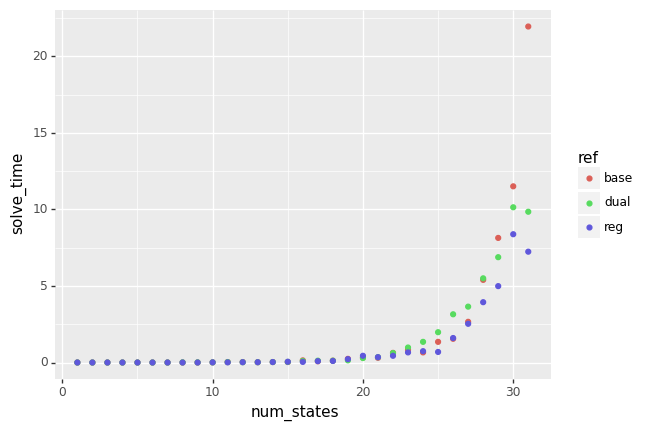

<ggplot: (316498584)>

In [34]:
ggplot(df, aes(x="num_states", y="solve_time", color="ref")) + geom_point() 